# Step 1 - Climate Analysis and Exploration

In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta, datetime

### Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
database = '../Resources/hawaii.sqlite'

In [5]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database}")
conn=engine.connect()

In [6]:
#Use SQLAlchemy `automap_base()` to reflect your tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
#Save a reference to those classes called `Station` and `Measurement
Station=Base.classes.station
Measurement=Base.classes.measurement

In [8]:
# Link Python to the database by creating an SQLAlchemy session.
session=Session(bind=engine)

## Precipitation Analysis

In [9]:
#Start by finding the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).first()
max_date[0]

'2017-08-23'

In [10]:
x= datetime.strptime(max_date[0], '%Y-%m-%d')
min_date = x - dt.timedelta(days=365)
min_date = min_date.strftime('%Y-%m-%d')
min_date

'2016-08-23'

In [11]:
#Using this date, retrieve the last 12 months of precipitation data by querying the 12 preceding months of data. 
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= min_date)

In [12]:
session.close()

In [13]:
precip_df = pd.DataFrame(precip, columns=['date', 'prcp'])
precip_df.set_index('date')
precip_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [14]:
#Select only the `date` and `prcp` values
#Load the query results into a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql('select date, prcp from measurement where date >= "2016-08-23"', conn, index_col='date')
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [15]:
#Sort the DataFrame values by `date`
precip_df.sort_values('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


In [16]:
xtick_labels=('2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10')
x_axis = precip_df.index
y_axis = precip_df.prcp

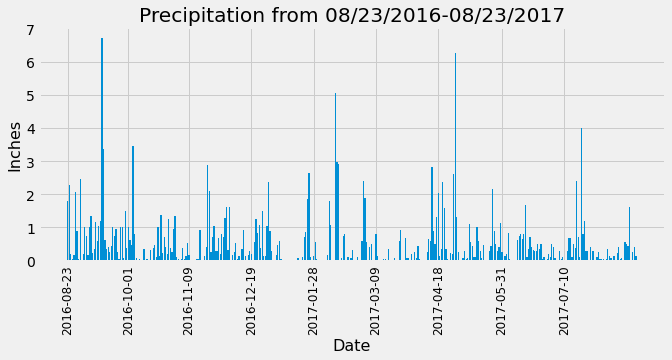

In [17]:
#Plot the results using the DataFrame `plot` method.

plt.figure(figsize=(10,4))
plt.bar(x_axis, y_axis)
plt.xticks([value for value in xtick_labels], rotation='vertical', fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Inches', fontsize=16)
plt.title('Precipitation from 08/23/2016-08/23/2017')
plt.savefig('../Images/Precipitation_bar.png')
plt.show()

In [18]:
clean_precip_df=precip_df.dropna()
clean_precip_df.sort_values('date').head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [19]:
clean_xtick_labels=('2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10')
clean_x_axis = clean_precip_df.index
clean_y_axis = clean_precip_df.prcp

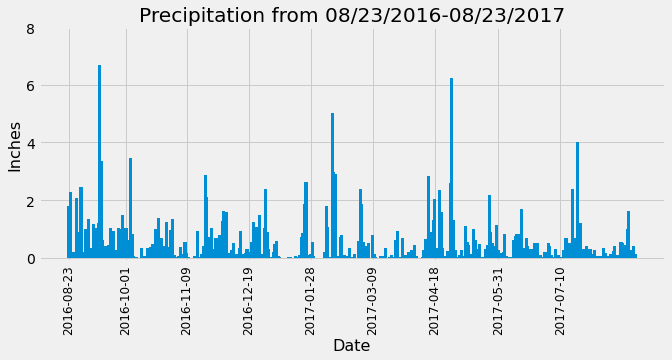

In [34]:
#Plot the results using the DataFrame `plot` method.

plt.figure(figsize=(10,4))
plt.bar(clean_x_axis, clean_y_axis, width=2)
plt.xticks([value for value in clean_xtick_labels], rotation='vertical', fontsize=12)
plt.ylim(-.1,8)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Inches', fontsize=16)
plt.title('Precipitation from 08/23/2016-08/23/2017')
plt.savefig('../Images/Precipitation_bar_clean.png', bbox_inches='tight')
plt.show()

In [21]:
#Use Pandas to print the summary statistics for the precipitation data
clean_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [22]:
#Design a query to calculate the total number of stations in the dataset.
nu_stations = session.query(Station).count()
nu_stations

9

In [23]:
#Design a query to find the most active stations (i.e. which stations have the most rows?).
#List the stations and observation counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.prcp)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.prcp).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [24]:
#Which station id has the highest number of observations?
max_obs = (active_stations[0])[0]
max_obs

'USC00519281'

In [25]:
#Using the most active station id (USC00519281), calculate the lowest, highest, and average temperature.

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==max_obs).scalar()
print(f'The lowest temperature for Station ID USC00519281 is {lowest_temp}.')

highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==max_obs).scalar()
print(f'The highest temperature for Station ID USC00519281 is {highest_temp}.')

avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==max_obs).scalar()
print(f'The average temperature for Station ID USC00519281 is {avg_temp}.')

The lowest temperature for Station ID USC00519281 is 54.0.
The highest temperature for Station ID USC00519281 is 85.0.
The average temperature for Station ID USC00519281 is 71.66378066378067.


In [26]:
#Design a query to retrieve the last 12 months of temperature observation data (TOBS).
    #Filter by the station with the highest number of observations.
temp_query = session.query(Measurement.tobs, Measurement.date).\
    filter(Measurement.date>='2016-08-23').\
    filter(Measurement.station=='USC00519281').\
    all()


In [27]:
temp_df = pd.DataFrame(temp_query, columns=['Temperature', 'Date'])
temp_df.head()

,Temperature,Date
0,77.0,2016-08-23
1,77.0,2016-08-24
2,80.0,2016-08-25
3,80.0,2016-08-26
4,75.0,2016-08-27


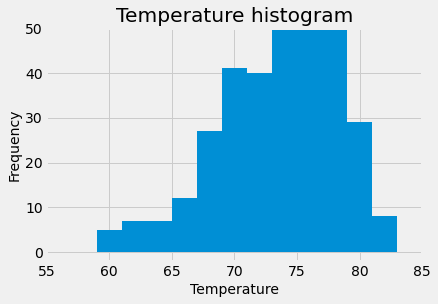

In [36]:
#Plot the results as a histogram with `bins=12`
plt.figsize=(8, 8)
plt.hist(temp_df.Temperature, bins=12)
plt.title('Temperature histogram')
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(55, 85)
plt.ylim(-2, 50)
plt.savefig('../Images/Temp_hist.png')
plt.show()

In [29]:
session.close()

# Step 2 - Climate App

#### Continued through app.py